In [2]:
import easyocr
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_local
import re
import math

In [3]:
def initialize_ocr(languages=['en']):
    """
    Initialize EasyOCR with specified languages.
    Args:
        languages: List of language codes
    Returns:
        reader: EasyOCR reader object
    """
    reader = easyocr.Reader(languages)
    return reader


In [4]:
def read_image(image_path):
    """
    Read an image file using OpenCV.
    Args:
        image_path: Path to the image file or image array
    Returns:
        image: OpenCV image object
    """
    if isinstance(image_path, str):
        image = cv2.imread(image_path)
    else:
        # Assume it's already an image array
        image = image_path
    return image

In [ ]:
def auto_adjust_gamma(image, gamma=1.0):
    """
    Automatically adjust gamma correction based on image brightness.
    Args:
        image: Input grayscale image
        gamma: Initial gamma value
    Returns:
        adjusted: Gamma-corrected image
    """
    # Calculate average brightness
    avg_brightness = np.mean(image) / 255.0
    
    # Adjust gamma based on brightness
    if avg_brightness < 0.4:
        gamma = 0.7  # Brighten dark images
    elif avg_brightness > 0.7:
        gamma = 1.3  # Darken bright images
    
    # Build a lookup table mapping pixel values [0, 255] to adjusted values
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    
    # Apply gamma correction using the lookup table
    return cv2.LUT(image, table)

In [6]:
def deskew_image(image):
    """
    Deskew the image to straighten text lines.
    Args:
        image: Grayscale image
    Returns:
        deskewed: Straightened image
    """
    # Use Hough Line Transform to detect lines
    edges = cv2.Canny(image, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi/180, 100)
    
    if lines is None or len(lines) == 0:
        return image  # No lines detected, return original
    
    # Calculate the average angle of detected lines
    angles = []
    for line in lines:
        rho, theta = line[0]
        if 0.25 < theta < 2.9:  # Filter out horizontal and vertical lines
            angles.append(theta)
    
    if not angles:
        return image  # No suitable angles found
    
    # Calculate median angle to avoid outliers
    median_angle = np.median(angles) - np.pi/2
    
    # Rotate to correct the skew
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, np.degrees(median_angle), 1.0)
    deskewed = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
    return deskewed

In [7]:
def adaptive_preprocessing(image):
    """
    Apply multiple preprocessing techniques and adaptively select the best one.
    Args:
        image: OpenCV image object
    Returns:
        best_image: Best preprocessed image for OCR
        all_images: Dictionary of all preprocessed versions
    """
    # Convert to grayscale if not already
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # Apply multiple preprocessing techniques
    processed_images = {}
    
    # 1. Basic grayscale
    processed_images['gray'] = gray
    
    # 2. Standard binary threshold
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    processed_images['binary'] = binary
    
    # 3. Gaussian blur + binary threshold
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, blurred_binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    processed_images['blurred_binary'] = blurred_binary
    
    # 4. Adaptive threshold
    adaptive = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                     cv2.THRESH_BINARY, 11, 2)
    processed_images['adaptive'] = adaptive
    
    # 5. Local threshold
    local_thresh = threshold_local(gray, 25, offset=5, method="gaussian")
    local_binary = (gray > local_thresh).astype("uint8") * 255
    processed_images['local_binary'] = local_binary
    
    # 6. Gamma correction
    gamma_corrected = auto_adjust_gamma(gray)
    processed_images['gamma'] = gamma_corrected
    
    # 7. Denoised
    denoised = cv2.fastNlMeansDenoising(gray, None, 10, 7, 21)
    processed_images['denoised'] = denoised
    
    # 8. Contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    processed_images['enhanced'] = enhanced
    
    # 9. Edge detection + dilation for focusing on text boundaries
    edges = cv2.Canny(gray, 100, 200)
    kernel = np.ones((2, 2), np.uint8)
    dilated_edges = cv2.dilate(edges, kernel, iterations=1)
    processed_images['edges'] = dilated_edges
    
    # 10. Deskewed image
    deskewed = deskew_image(gray)
    processed_images['deskewed'] = deskewed
    _, deskewed_binary = cv2.threshold(deskewed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    processed_images['deskewed_binary'] = deskewed_binary
    
    # For receipt-specific processing, determine dominant text color
    avg_pixel = np.mean(gray)
    if avg_pixel > 127:  # Light background, dark text
        inverted = cv2.bitwise_not(gray)
        processed_images['inverted'] = inverted
    
    # Return all processed images with a default "best" one (adaptive is usually good for receipts)
    return processed_images['adaptive'], processed_images

In [8]:
def detect_text_with_multiple_preprocessings(reader, image):
    """
    Try multiple preprocessing methods and combine results.
    Args:
        reader: EasyOCR reader object
        image: OpenCV image object
    Returns:
        combined_results: Combined list of detected text
        best_image: Best preprocessed image
        all_images: All preprocessed versions
    """
    # Get all preprocessed versions
    best_image, all_images = adaptive_preprocessing(image)
    
    # List of preprocessing methods to try, in order of typical effectiveness for receipts
    methods_to_try = ['adaptive', 'binary', 'deskewed_binary', 'gray', 'enhanced']
    
    all_results = []
    confidence_sums = {method: 0 for method in methods_to_try}
    result_counts = {method: 0 for method in methods_to_try}
    
    # Try OCR on each preprocessed image
    for method in methods_to_try:
        if method in all_images:
            try:
                results = reader.readtext(
                    all_images[method],
                    paragraph=False,
                    contrast_ths=0.1,
                    adjust_contrast=0.8,
                    text_threshold=0.6,
                    link_threshold=0.5,
                    low_text=0.3,
                )
                
                # Track confidence scores
                for _, _, prob in results:
                    confidence_sums[method] += prob
                    result_counts[method] += 1
                
                # Store results with preprocessing method tag
                for result in results:
                    bbox, text, prob = result
                    all_results.append((bbox, text, prob, method))
            except Exception as e:
                print(f"Error with {method} preprocessing: {e}")
    
    # Calculate average confidence per method
    avg_confidence = {}
    for method in methods_to_try:
        if result_counts[method] > 0:
            avg_confidence[method] = confidence_sums[method] / result_counts[method]
        else:
            avg_confidence[method] = 0
    
    # Find best preprocessing method based on average confidence
    best_method = max(avg_confidence, key=avg_confidence.get) if avg_confidence else 'adaptive'
    best_image = all_images[best_method]
    
    # Remove duplicates by comparing text and locations
    filtered_results = []
    seen_texts = set()
    
    for bbox, text, prob, method in all_results:
        # Create a key based on text and approximate location
        center_x = sum(point[0] for point in bbox) / 4
        center_y = sum(point[1] for point in bbox) / 4
        location_key = f"{text}_{int(center_x//10)}_{int(center_y//10)}"
        
        if location_key not in seen_texts:
            seen_texts.add(location_key)
            filtered_results.append((bbox, text, prob))
    
    return filtered_results, best_image, all_images


In [9]:
def draw_text_boxes(image, results):
    """
    Draw bounding boxes and text on the image.
    Args:
        image: OpenCV image object
        results: List of detected text with coordinates
    Returns:
        annotated_image: Image with drawn boxes and text
    """
    # Create a copy of the image to draw on
    if len(image.shape) == 2:  # Grayscale
        annotated_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else:  # Already color
        annotated_image = image.copy()
    
    # Sort results by y-coordinate for cleaner visualization
    sorted_results = sorted(results, key=lambda x: x[0][0][1])
    
    # Define colors based on confidence
    def get_color(conf):
        if conf > 0.8:
            return (0, 255, 0)  # Green for high confidence
        elif conf > 0.6:
            return (0, 255, 255)  # Yellow for medium confidence
        else:
            return (0, 0, 255)  # Red for low confidence
    
    for (bbox, text, prob) in sorted_results:
        # Convert bbox coordinates to integers
        bbox = np.array(bbox).astype(np.int32)
        
        # Draw rectangle around text
        color = get_color(prob)
        cv2.polylines(annotated_image, [bbox], True, color, 2)
        
        # Create background for text for better readability
        text_to_show = f"{text[:15]}... {prob:.2f}" if len(text) > 15 else f"{text} {prob:.2f}"
        (text_width, text_height), _ = cv2.getTextSize(text_to_show, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
        cv2.rectangle(annotated_image, 
                     (bbox[0][0], bbox[0][1] - text_height - 10),
                     (bbox[0][0] + text_width, bbox[0][1]),
                     (0, 0, 0), -1)
        
        # Add text above the box
        cv2.putText(annotated_image, text_to_show,
                   (bbox[0][0], bbox[0][1] - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    
    return annotated_image

In [10]:
def display_preprocessing_steps(original_image, preprocessed_images, annotated_image):
    """
    Display key preprocessing steps and final result.
    Args:
        original_image: Original image
        preprocessed_images: Dictionary of preprocessed images
        annotated_image: Final annotated image
    """
    # Select key preprocessing methods to display
    display_methods = ['gray', 'binary', 'adaptive', 'enhanced', 'deskewed_binary']
    methods_to_show = [m for m in display_methods if m in preprocessed_images]
    
    # Calculate grid size based on number of images to display
    total_images = len(methods_to_show) + 2  # original + annotated + preprocessing steps
    cols = min(3, total_images)
    rows = math.ceil(total_images / cols)
    
    plt.figure(figsize=(cols * 6, rows * 5))
    
    # Display original image
    plt.subplot(rows, cols, 1)
    if len(original_image.shape) == 3:
        plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    # Display preprocessed images
    for i, method in enumerate(methods_to_show):
        plt.subplot(rows, cols, i + 2)
        plt.imshow(preprocessed_images[method], cmap='gray')
        plt.title(f'Preprocessing: {method}')
        plt.axis('off')
    
    # Display annotated image
    plt.subplot(rows, cols, total_images)
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    plt.title('Detected Text')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [11]:
def extract_generic_text_data(results, image_shape):
    """
    Extract structured data from generic receipt OCR without making assumptions.
    Args:
        results: List of detected text with coordinates
        image_shape: Shape of the image (height, width)
    Returns:
        structured_data: Dictionary with structured information
    """
    # Initialize output structure
    structured_data = {
        'text_blocks': [],       # All text blocks in reading order
        'possible_headers': [],  # Text at the top - likely headers/store info
        'possible_totals': [],   # Lines with numbers that might be totals
        'possible_items': [],    # Lines that might be items
        'possible_dates': [],    # Text that looks like dates
        'possible_barcodes': [], # Text that looks like numeric codes
        'location_map': {}       # Map dividing receipt into regions
    }
    
    # Sort by y-coordinate (top to bottom)
    sorted_by_y = sorted(results, key=lambda x: x[0][0][1])
    
    # Define common patterns
    date_pattern = re.compile(r'\d{1,2}[/\-\.]\d{1,2}[/\-\.]\d{2,4}')
    time_pattern = re.compile(r'\d{1,2}:\d{2}(:\d{2})?(\s?[APap][Mm])?')
    price_pattern = re.compile(r'\$?\d+\.\d{2}')
    barcode_pattern = re.compile(r'\d{12,}')
    
    # Get image dimensions
    height, width = image_shape[:2]
    
    # Divide the receipt into regions (top 20%, middle 60%, bottom 20%)
    top_region = height * 0.2
    bottom_region = height * 0.8
    
    # Process each text element
    for i, (bbox, text, prob) in enumerate(sorted_by_y):
        # Calculate center point of bounding box
        center_x = sum(point[0] for point in bbox) / 4
        center_y = sum(point[1] for point in bbox) / 4
        
        # Add to text blocks with position information
        text_block = {
            'text': text,
            'confidence': prob,
            'position': {
                'x': int(center_x),
                'y': int(center_y),
                'x_normalized': center_x / width,
                'y_normalized': center_y / height
            },
            'index': i  # Preserve original detection order
        }
        structured_data['text_blocks'].append(text_block)
        
        # Analyze text content and position
        if center_y < top_region:
            structured_data['possible_headers'].append(text_block)
        
        # Look for possible dates
        if date_pattern.search(text):
            text_block['type'] = 'date'
            structured_data['possible_dates'].append(text_block)
        
        # Look for possible times
        if time_pattern.search(text):
            text_block['type'] = 'time'
        
        # Look for possible prices
        if price_pattern.search(text):
            text_block['type'] = 'price'
            # Check if it might be a total
            if 'TOTAL' in text.upper() or center_y > bottom_region:
                structured_data['possible_totals'].append(text_block)
        
        # Look for possible barcodes or item codes
        if barcode_pattern.search(text):
            text_block['type'] = 'barcode'
            structured_data['possible_barcodes'].append(text_block)
        
        # Identify potential items (middle of receipt, might have numbers/codes)
        if top_region < center_y < bottom_region:
            # Look for patterns like "ITEM X.XX" or item with a code
            if re.search(r'\d+\.\d{2}', text) or re.search(r'\d{6,}', text):
                text_block['type'] = 'possible_item'
                structured_data['possible_items'].append(text_block)
    
    # Try to identify potential store name (usually at the top with high confidence)
    if structured_data['possible_headers']:
        # Sort headers by confidence and y-position (top ones first)
        top_headers = sorted(
            structured_data['possible_headers'],
            key=lambda x: (-x['confidence'], x['position']['y'])
        )
        
        if top_headers:
            structured_data['possible_store_name'] = top_headers[0]['text']
    
    return structured_data

In [12]:
def format_extracted_data(structured_data):
    """
    Format extracted data for human-readable output.
    Args:
        structured_data: Dictionary with structured information
    Returns:
        formatted_output: String with formatted output
    """
    output = []
    
    # Add store name if found
    if 'possible_store_name' in structured_data:
        output.append(f"Store: {structured_data['possible_store_name']}")
    
    # Add dates if found
    if structured_data['possible_dates']:
        dates = [item['text'] for item in structured_data['possible_dates']]
        output.append(f"Date(s): {', '.join(dates)}")
    
    # Add total if found
    if structured_data['possible_totals']:
        totals = [item['text'] for item in structured_data['possible_totals']]
        output.append(f"Possible Total(s): {', '.join(totals)}")
    
    # Add items if found
    if structured_data['possible_items']:
        output.append("\nPossible Items:")
        for item in structured_data['possible_items'][:10]:  # Limit to first 10
            output.append(f"- {item['text']} ({item['confidence']:.2f})")
        
        if len(structured_data['possible_items']) > 10:
            output.append(f"... and {len(structured_data['possible_items']) - 10} more items")
    
    # Add all text in reading order
    output.append("\nAll Detected Text (in reading order):")
    sorted_blocks = sorted(structured_data['text_blocks'], 
                          key=lambda x: (x['position']['y'] // 30, x['position']['x']))
    for block in sorted_blocks:
        output.append(f"{block['text']} ({block['confidence']:.2f})")
    
    return "\n".join(output)


In [13]:
# Main function to process a receipt image
def process_receipt(image_path, show_preprocessing=True):
    """
    Process a receipt image with adaptive OCR.
    Args:
        image_path: Path to image or image object
        show_preprocessing: Whether to show preprocessing steps
    Returns:
        results: OCR results
        structured_data: Extracted structured data
        annotated_image: Annotated image
    """
    # Initialize OCR reader
    reader = initialize_ocr(['en'])
    
    # Read the image
    image = read_image(image_path)
    
    # Detect text using multiple preprocessing methods
    results, best_image, all_preprocessed = detect_text_with_multiple_preprocessings(reader, image)
    
    # Draw boxes on the original image
    annotated_image = draw_text_boxes(image, results)
    
    # Extract structured data
    structured_data = extract_generic_text_data(results, image.shape)
    
    # Display results if requested
    if show_preprocessing:
        display_preprocessing_steps(image, all_preprocessed, annotated_image)
    
    # Format and print summary
    formatted_output = format_extracted_data(structured_data)
    print(formatted_output)
    
    return results, structured_data, annotated_image

In [14]:
def detect_text_with_multiple_preprocessings(reader, image):
    """
    Try multiple preprocessing methods and combine results,
    keeping only the highest confidence instance of each unique word.
    
    Args:
        reader: EasyOCR reader object
        image: OpenCV image object
    
    Returns:
        combined_results: Combined list of detected text
        best_image: Best preprocessed image
        all_images: All preprocessed versions
    """
    # Get all preprocessed versions
    best_image, all_images = adaptive_preprocessing(image)
    
    # List of preprocessing methods to try, in order of typical effectiveness for receipts
    methods_to_try = ['adaptive', 'binary', 'deskewed_binary', 'gray', 'enhanced']

    # Dictionary to track highest confidence for each unique word
    word_confidence_map = {}
    
    # Try OCR on each preprocessed image
    for method in methods_to_try:
        if method in all_images:
            try:
                results = reader.readtext(
                    all_images[method],
                    paragraph=False,
                    contrast_ths=0.1,
                    adjust_contrast=0.8,
                    text_threshold=0.6,
                    link_threshold=0.5,
                    low_text=0.3,
                )
                
                # Process each result
                for bbox, text, prob in results:
                    # Normalize text (lowercase, strip whitespace)
                    normalized_text = text.lower().strip()
                    
                    # Update if this is a new word or has higher confidence
                    if (normalized_text not in word_confidence_map or 
                        prob > word_confidence_map[normalized_text]['confidence']):
                        # Calculate center point of bounding box
                        center_x = sum(point[0] for point in bbox) / 4
                        center_y = sum(point[1] for point in bbox) / 4
                        
                        word_confidence_map[normalized_text] = {
                            'bbox': bbox,
                            'text': text,
                            'confidence': prob,
                            'center_x': center_x,
                            'center_y': center_y,
                            'preprocessing_method': method
                        }
            
            except Exception as e:
                print(f"Error with {method} preprocessing: {e}")
    
    # Convert the highest confidence words to results format
    filtered_results = [
        (entry['bbox'], entry['text'], entry['confidence']) 
        for entry in word_confidence_map.values()
    ]
    
    # Sort results by y-coordinate to maintain reading order
    filtered_results.sort(key=lambda x: sum(point[1] for point in x[0]) / 4)
    
    return filtered_results, best_image, all_images

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


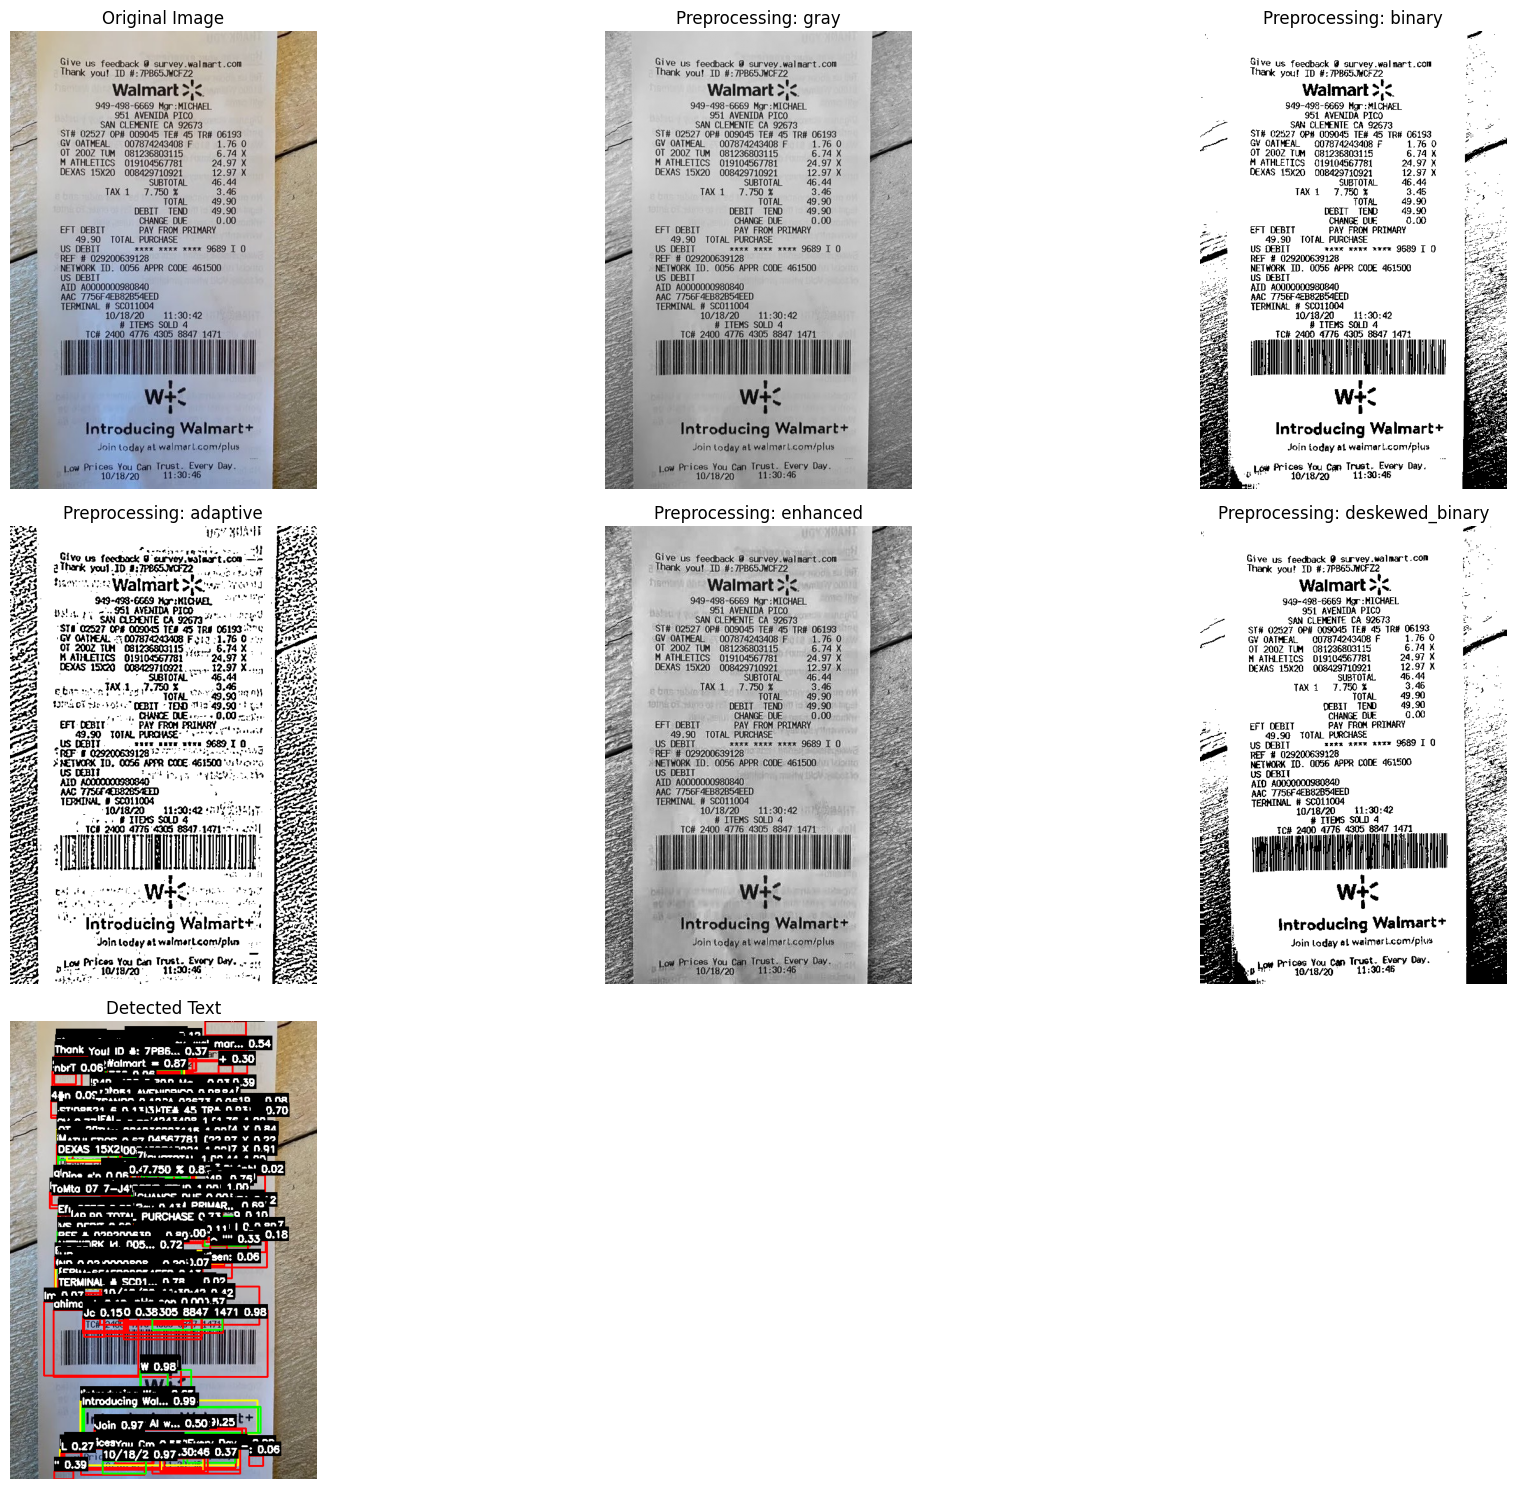

Store: 951
Date(s): 10/18/20, 11.31.46
Possible Total(s): 11.31.46, 11.30:46, "11.30:46

Possible Items:
- {E483573R# 05193 (0.08)
- Op# 003045 TE# 45 TR# 06193_ (0.11)
- 861930 (0.33)
- 007874243408 F (1.00)
- 007874243408 (1.00)
- 1.76 (1.00)
- 200Z TuH  081236803115 (0.20)
- 26.97 % (0.28)
- 6.74 X (0.84)
- 081236303115 (0.99)
... and 25 more items

All Detected Text (in reading order):
U6" # (0.17)
Give (0.97)
{na" (0.03)
Give us Teedback 0 (0.54)
u3 Iaddk (0.15)
feedback 0 (0.90)
Give us feedback @ suvey_walnt.con (0.49)
Give Us feedback @ survey_walmart.con (0.55)
~A" (0.12)
#asztc (0.01)
survey .walmart-can (0.47)
survey .wal mart-com (0.54)
Tnak (0.94)
Youi JD , (0.06)
Thank You! ID #: 7PB65 ICFZZ (0.21)
Thank you: ID #: 7PB6SJNCFZ2 (0.35)
~Thank youl ID #: 7PB6SJNCF7Z (0.24)
You! ID #: 7PB65WCFZ2 (0.37)
+ (0.30)
nbrT (0.06)
S6r5: (0.02)
949-498 (0.80)
Walmart = (0.87)
e569 (0.18)
Walmart _ (0.71)
949-498-8669_WI : HICHAEL (0.21)
949-498-6669 Mgr : MICHAEL (0.93)
949-498-6669_M

In [18]:
# Example usage
if __name__ == "__main__":
    # Replace with your image path
    image_path = 'images/2.jpg'
    
    # Process the receipt
    results, structured_data, annotated_image = process_receipt(image_path)